In [31]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [33]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/Users/an/Documents/0_mfpt/repptis2/"
zero_minus_one = True
inputfile = indir + "/out.rst"
#inputfile = indir + "/retis.rst"

# new data Elias
#---------------
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/flat_w-walls/browian-gamma5/100k-cycles/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/flat_w-walls/newtonian/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/flat_w-walls/dt-0.00002/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/flat_w-walls/langevin-gamma5/REPPTIS"
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump3-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosdip2-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbumpmeta-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosdipmeta-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3"
zero_minus_one = False
inputfile = indir + "/out.rst"

# old data bump An
#------------------
#indir = "/Users/an/wwork/current-work/0_TitusEnrico/repp/1D-flat.ppr-Febr6-2022d/"
##indir = "/Users/an/wwork/current-work/0_TitusEnrico/repp/bump-ppretis/"
#inputfile = indir + "/out.rst"

import os
import glob
os.chdir(indir)
print(os.getcwd())

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/004']


In [37]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 29998, 29999, 30000]),
 'flags': array(['ACC', 'ACC', 'ACC', ..., 'FTL', 'ACC', 'FTL'], dtype='<U3'),
 'generation': array(['ki', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.0998876 , -0.09985364, -0.09985525, ..., -0.09992359,
       -0.09988771, -0.09993588]),
 'lambmins': array([-0.39183776, -0.39233455, -0.29408372, ..., -0.12956467,
       -0.10524033, -0.11456793]),
 'lengths': array([3189, 4157, 3533, ...,  153,  155,  238]),
 'lmrs': array(['RMR', 'RMR', 'RMR', ..., 'RM*', 'RMR', 'RM*'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DAT

# Analysis

In [38]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    if i != 1:
        print("Calculating path lengths.")
        set_tau_distrib(pathensembles[i])
        print("Done.")
    #else:
        #TODO problem with ...
    if i > 1:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")
    #else:
        # TODO problem with ....

0
Calculating path lengths.
Done.
1
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.


In [39]:
# Analyze the pptis simulation.
# Analysis output is saved to the data dictionary.
data = {}
for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    pathtypes = ("LML", "LMR", "RML", "RMR")
    pathtype_cycles = {}
    for ptype in pathtypes:
        pathtype_cycles[ptype] = unwrap_by_weight(
                (pe.lmrs == ptype).astype(int), pe.weights)
    
    # running average analysis: ["running"]
    data[i] = {}
    data[i]["running"] = {}
    data[i]["running"]["plocal"] = {}
    # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    for (ptype, p_loc) in zip(pathtypes, 
                              running_avg_local_probs(pathtype_cycles, 
                                                      pe.weights, tr = False)):
        data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
Weights of the different paths:
wRMR = 0
wRML = 7478
wLMR = 7514
wLML = 15010
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 0.3335997158586397
pLML = 0.6664002841413603
doing pathensemble 2
Weights of the different paths:
wRMR = 693
wRML = 14420
wLMR = 14148
wLML = 739
Local crossing probabilities:
pRMR = 0.04585456229735989
pRML = 0.9541454377026402
pLMR = 0.9503593739504266
pLML = 0.04964062604957346
doing pathensemble 3
Weights of the different paths:
wRMR = 4096
wRML = 10984
wLMR = 10953
wLML = 3969
Local crossing probabilities:
pRMR = 0.2716180371352785
pRML = 0.7283819628647215
pLMR = 0.7340168878166465
pLML = 0.26598311218335347
doing pathensemble 4
Weights of the different paths:
wRMR = 703
wRML = 14181
wLMR = 14338
wLML = 779
Local crossing probabilities:
pRMR = 0.0472319269013706
pRML = 0.9527680730986294
pLMR = 0.9484686114969901
pLML = 0.05153138850300985


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools-0.1-py3.10.egg/tistools/repptis_analysis.py:555: RuntimeWarning: invalid value encountered in divide
  p_PP = cumsums['RMR']/(cumsums['RML']+cumsums['RMR'])
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools-0.1-py3.10.egg/tistools/repptis_analysis.py:556: RuntimeWarning: invalid value encountered in divide
  p_PN = cumsums['RML']/(cumsums['RML']+cumsums['RMR'])


In [40]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Pcross with recursive relations

In [41]:
# Global crossing probabilities
# WITHOUT ERRORS #  
# Full data 
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)
print(Pcrossfull)

[1.0, 0.3335997158586397, 0.317039617113457, 0.23558576407175627, 0.22691196234246697]


This should be the same as the repptis_report.pdf value: 0.22691196234246697
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_49314/2225595878.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


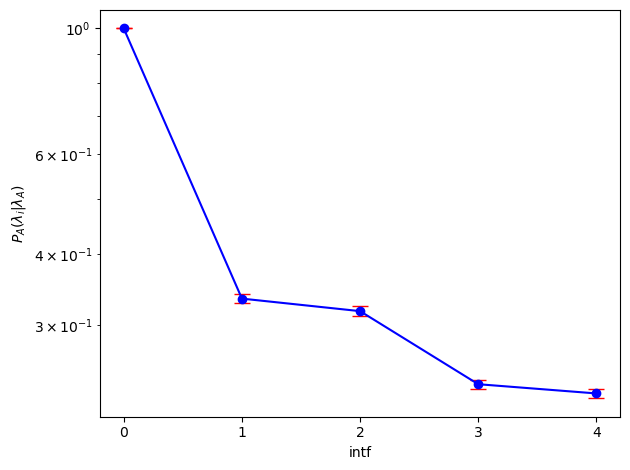

: 

In [64]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
# ax.plot(Pcrossfull, "o", c = "r")

# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps Langevin
ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.006395, Pcrossfull[2]*0.02092401277, Pcrossfull[3]*0.01899419954, Pcrossfull[4]*0.01929952226], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat Langevin
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.013684, Pcrossfull[2]*0.0825226801, Pcrossfull[3]*0.01027325454, Pcrossfull[4]*0.02130629112], fmt="-o", c = "b", ecolor="r", capsize=6)

ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [43]:
# TODO I am not sure what this is

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

This should be the same as the repptis_report.pdf value: 0.22691196234246697


# Now work with MSM

In [44]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import vector_G

In [45]:
def create_labels_states(N):
    assert N>=3
    labels1 = ["0-     ","B      "]
    labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR"]
    if N>3:
        for i in range(1,N-2):
            labels2.append(str(i)  +"+- RML")
            labels2.append(str(i)  +"+- RMR")
            labels2.append(str(i+1)+"+- LML")
            labels2.append(str(i+1)+"+- LMR")
    return labels1, labels2

def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [46]:
print(interfaces)
N = len(interfaces)
assert N >= 4
NS = 4*N-5
print("N", N)
print("len pmms", len(pmms))
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)

[-0.1, 0.0, 0.1, 0.2, 0.3]
N 5
len pmms 4
NS 15


In [47]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
M = construct_M(pmms, pmps, ppms, ppps, NS, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

mm [0.6664002841413603, 0.04964062604957346, 0.26598311218335347, 0.05153138850300985]
mp [0.3335997158586397, 0.9503593739504266, 0.7340168878166465, 0.9484686114969901]
pm [1.0, 0.9541454377026402, 0.7283819628647215, 0.9527680730986294]
pp [0.0, 0.04585456229735989, 0.2716180371352785, 0.0472319269013706]
sum [1. 1. 1. 1.]
sum [1. 1. 1. 1.]


In [48]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (15, 15)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.         0.66640028 0.33359972 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.04964063 0.95035937
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.26598311 0.73401689 0.         0.
  0.       

# Look at this Markov model

In [49]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[-1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
 -4.50762232e-01+5.87301846e-01j -4.50762232e-01-5.87301846e-01j
  4.50762232e-01+5.87301846e-01j  4.50762232e-01-5.87301846e-01j
 -7.38961710e-17+1.54701601e-01j -7.38961710e-17-1.54701601e-01j
 -2.14378582e-08+0.00000000e+00j  2.14378575e-08+0.00000000e+00j
  1.19767397e-16+0.00000000e+00j -1.35438925e-17+1.37422891e-17j
 -1.35438925e-17-1.37422891e-17j  5.01956607e-19+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
[-1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
 -4.50762232e-01+5.87301846e-01j -4.50762232e-01-5.87301846e-01j
  4.50762232e-01+5.87301846e-01j  4.50762232e-01-5.87301846e-01j
 -2.62570882e-16+1.54701601e-01j -2.62570882e-16-1.54701601e-01j
  2.34199878e-16+5.29571960e-09j  2.34199878e-16-5.29571960e-09j
 -4.66018949e-17+0.00000000e+00j  9.21958022e-17+5.64649517e-18j
  9.21958022e-17-5.64649517e-18j  5.62521302e-17+0.00000000e+00j
 -2.38298746e-18+0.00000000e+00j]


In [50]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.66640028 0.         0.         0.         0.0165601  0.31703962
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
1.0
[0.         0.44408934 0.22231095 0.0165601  0.         0.
 0.         0.         0.08432718 0.23271243 0.         0.
 0.         0.         0.        ]
1.0
[0.46064944 0.         0.         0.         0.01103565 0.21127529
 0.0804604  0.00386679 0.         0.         0.         0.
 0.01199199 0.22072044 0.        ]
1.0
[0.         0.30697692 0.15367252 0.09149605 0.         0.
 0.         0.         0.05722416 0.15791792 0.00873475 0.00325724
 0.         0.         0.22072044]
1.0
[0.61919341 0.         0.         0.         0.0076284  0.14604412
 0.06293439 0.00302452 0.         0.         0.         0.
 0.00830558 0.15286958 0.        ]
1.0000000000000002
[0.         0.41263066 0.20656274 0.0705628  0.         0.
 0.         0.         0.03964974 0.1094189  0.00604963 0.00225595
 0.       

# Pcross with MSM

In [51]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 0.6801923129893167
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.7157211594198443
state 1+- RML 0.0
state 1+- RMR 0.7157211594198443
state 2+- LML 0.0328190804921559
state 2+- LMR 0.9631819784889574
state 2+- RML 0.0328190804921559
state 2+- RMR 0.9631819784889574
state 3+- LML 0.2855224246695364
state 3+- LMR 1.0
Y
state 0-      0.22691196234246697
state B       0.0
state 0+- LML 0.0
state 0+- LMR 0.6801923129893167
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.7157211594198443
state 1+- RML 0.0
state 1+- RMR 0.7157211594198443
state 2+- LML 0.0328190804921559
state 2+- LMR 0.9631819784889574
state 2+- RML 0.0328190804921559
state 2+- RMR 0.9631819784889574
state 3+- LML 0.2855224246695365
state 3+- LMR 1.0
global crossing prob [0.22691196]


# Collecting times

In [52]:
#TODO I need data too?

In [53]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [54]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [55]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name[-3:]}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [56]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

Collect tau
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/004
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/HPC/cosbump2-walls/langevin-gamma5/REPPTIS/001
Collect tau1
Collect tau2
Collect taum


In [57]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

tau
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0        2838.1
1 001          773.1         425.7         432.4           0.0
2 002         1589.0         843.7         843.5        1557.6
3 003         3720.1        1795.2        1777.5        3789.3
4 004         1589.8         841.8         846.2        1597.4

tau1
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0           0.0
1 001            0.0           0.0         432.4           0.0
2 002          634.7         413.3         415.6         615.7
3 003          495.6         398.6         388.5         506.9
4 004          613.6         417.6         422.3         602.2

tau_m
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0        2838.1
1 001          773.1           0.0           0.0           0.0
2 002          348.1           5.3    

In [58]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [59]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[2838.12962469  773.09933378  425.66382752  432.35303557 1589.01894452
  843.73056262  843.5334258  1557.61183261 3720.13983371 1795.19181959
 1777.47496358 3789.25830078 1589.84724005  841.83603013    0.        ]


tau1
[  0.           0.           0.         432.35303557 634.71989175
 413.34230987 415.63127601 615.70562771 495.58226253 398.58038893
 388.53095412 506.91577148 613.5648267  417.61856605   0.        ]
taum
[2838.12962469  773.09933378    0.            0.          348.08660352
    5.33884648    5.44722607  373.28138528 2722.24162257  997.45923491
  990.96913693 2788.20605469  362.41848524    6.9708467     0.        ]
tau2
[  0.           0.         425.66382752   0.         606.21244926
 425.04940628 422.45492372 568.62481962 502.3159486  399.15219575
 397.97487254 494.13647461 613.86392811 417.24661738   0.        ]


tau = tau1+taum+tau2 => difference is 6.462348535570529e-27


# Compute tau for [0+]

In [60]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 773.0993337774817
state 0+- LMR 3218.6535202956848
state 0+- RML 0.0
state 1+- LML 954.299052774019
state 1+- LMR 2889.0309977609877
state 1+- RML 427.9021497919556
state 1+- RMR 3400.5489499106193
state 2+- LML 3788.7691388526637
state 2+- LMR 1976.649532443134
state 2+- RML 1953.1555771443623
state 2+- RMR 3862.3806310817417
state 3+- LML 3448.0179520947786
state 3+- LMR 424.2174640814619
H
state 0-      1588.9355155168605
state B       0.0
state 0+- LML 0.0
state 0+- LMR 3218.6535202956843
state 0+- RML 0.0
state 1+- LML 606.212449255751
state 1+- LMR 2883.6921512809195
state 1+- RML 422.4549237170596
state 1+- RMR 3027.2675646292337
state 2+- LML 1066.5275162777075
state 2+- LMR 979.1902975303246
state 2+- RML 962.1864402179236
state 2+- RMR 1074.1745763942417
state 3+- LML 3085.599466857295
state 3+- LMR 417.24661738038776
interesting
[1588.93551552]


In [61]:
print(h1[0])

[1588.93551552]


# Flux

In [62]:
flux = 1/(tau[0]+h1[0])
dt = 0.0002
# dt = 0.00002
# dt = 0.01
flux
print(flux/dt, "1/time")

[1.12941641] 1/time
